<a href="https://colab.research.google.com/github/Pushkar-Parker/deep_learning_colab_notebooks/blob/main/02_python_neural_network_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **What we will be doing throughout this notebook :**

* Make architecture of the neural network
* Getting Binary dataset ready
* Building a Pytorch classification model
* Fitting the model to the data (training)
* Making predictions (inference)
* Improving the model (from a model prespective)
* Non-linearity
* Replicating non-linear function
* Putting it all together
* Some pointers for Binary and multiclass classification problem

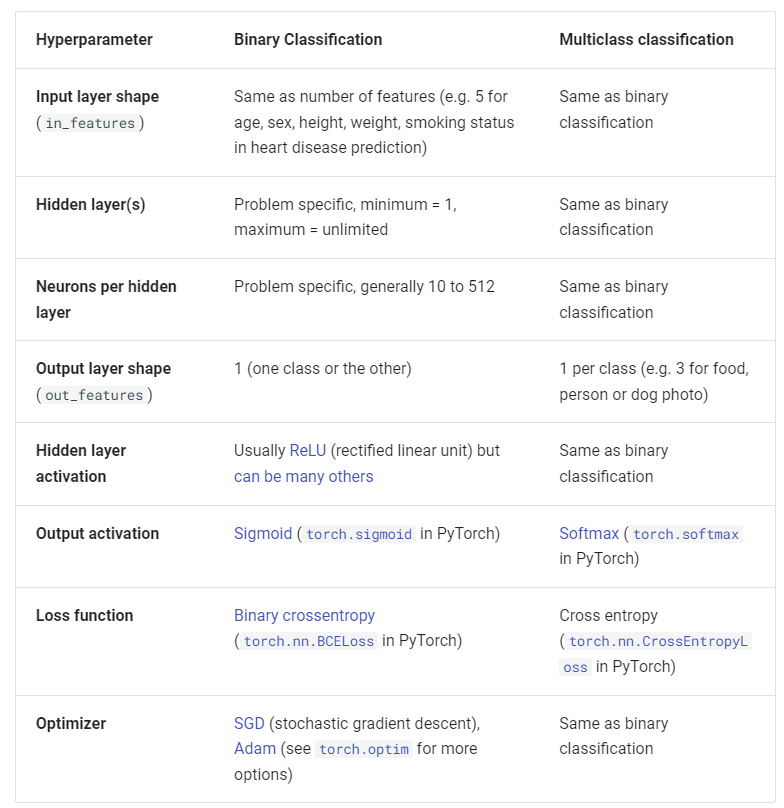

# **Making classification data**
* Making circle shaped dataset
* Making 1000 samples


In [1]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles

X, y = make_circles(
    n_samples,
    noise=0.03, # little bit noise
    random_state=101 # setting random state
)

# print(f'first 5 features : \n{X[:5]}')
# print(f'\nfirst 5 labels : \n{y[:5]}')

type(X)

numpy.ndarray

**Making a dataframe**

In [2]:
import pandas as pd

circles = pd.DataFrame({"X1": X[:,0], "X2": X[:,1], "label": y})

circles.head()

,X1,X2,label
0,0.676218,0.497584,1
1,-0.812723,-0.543010,0
2,0.192605,1.020086,0
3,-0.320621,-0.691720,1
4,-0.779619,0.645467,0


**Checking Class imbalance**
* As seen below the class is balanced

In [3]:
circles['label'].value_counts()

,count
label,
1,500
0,500


**Plotting the data**

* If any question regarding the shape of the dataset: https://stackoverflow.com/questions/59024167/i-have-some-questions-about-the-return-value-of-the-make-circles-function-in-pyt

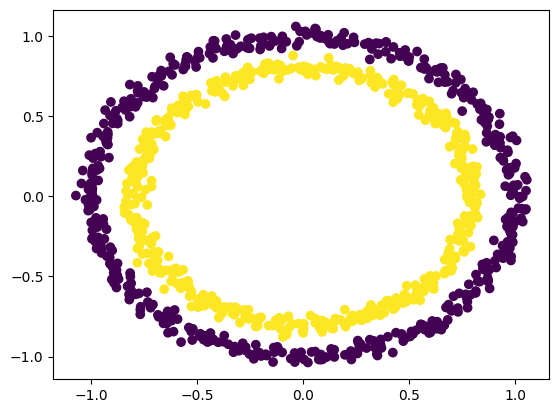

In [4]:
import matplotlib.pyplot as plt

# plt.scatter(x=X[:,0],
#             y=X[:,1],
#             c = y)


plt.scatter(x=circles["X1"],
            y=circles["X2"],
            c=y)
plt.show()

# **Turning data into Tensors**

In [5]:
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [6]:
X.dtype, y.dtype

(torch.float32, torch.float32)

**Splitting dataset into training and test dataset**

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

len(X_train), len(X_test), len(y_train), len(y_test)

(700, 300, 700, 300)

# **Building a model**

* We have got data ready
* Setting up device agnostic code
* Constructing a model by subclassing `nn.Module`
* Define optimiser and loss function
* Creating training loop

* Setting up agnostic code

In [8]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


* Constructing a model by subclassing `nn.Module`

In [9]:
import torch
from torch import nn

class circle_model_v0(nn.Module): # subclassing nn.Module
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # Activation input layer; 2 to 5
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # Hidden layer; 5 to 1

  def forward(self, x):
    return self.layer_2(self.layer_1(x))

model_0 = circle_model_v0().to(device)
model_0

circle_model_v0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

* Defining optimiser and loss function
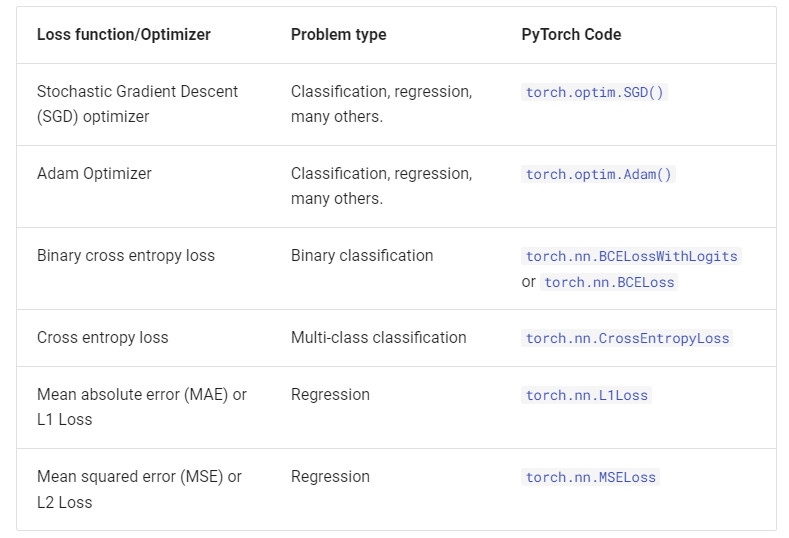

* Binary cross entropy loss has two functions:
`torch.nn.BCELosswithLogits` & `torch.nn.BCELoss`

* `torch.nn.BCELosswithLogits` contains a sigmoid in-built layer hence gives out more numerically stable outputs

In [10]:
# Creating Loss function
loss_fn = nn.BCEWithLogitsLoss()

# Creating optimiser
optimiser = torch.optim.SGD(model_0.parameters(), lr=0.1)


**Creating evaluation matrix**
* Creating instance to calculate accuracy

In [11]:
def accuracy(y_pred, y_test):
  correct = torch.eq(y_pred, y_test).sum().item() # torch.eq() calculates where two tensors are equal
  accuracy = (correct/len(y_pred))*100

  return accuracy

**Testing untrained model**


In [12]:
model_0.eval()

with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))[:5]

print(untrained_preds)
print(untrained_preds.shape, y_test.shape)

tensor([[-0.3210],
        [-0.4168],
        [-0.5284],
        [-0.4542],
        [-0.4678]])
torch.Size([5, 1]) torch.Size([300])


* As seen from the above outputs the `untrained_preds` are giving outputs which are different in format and shape from the binary values of `y_test`

* The values of `untrained_preds` are called **logits**

* These logits are calculated with the linear function `y = mx+b` therefore, the logits are having floats values

* We will have to convert these values into **prediction probabilities** using `sigmoid function` then convert those values into `binary values` using a decision boundary


In [13]:
untrained_preds_probs = torch.sigmoid(untrained_preds)
print(untrained_preds_probs)

tensor([[0.4204],
        [0.3973],
        [0.3709],
        [0.3884],
        [0.3851]])


In [14]:
untrained_preds_label = torch.round(untrained_preds_probs)
print(untrained_preds_label, untrained_preds_label.squeeze().shape)

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]]) torch.Size([5])


* Creating a function to convert logit to classification format

In [15]:
def logit_to_bin(value):
  y_logit = model_0(value).squeeze() # Getting Raw logits
  y_pred = torch.round(torch.sigmoid(y_logit)) # Raw logits ---> pred proba ---> y_pred (binary)

  return y_pred, y_logit

**Creating training loop**

In [16]:
import numpy as np

torch.manual_seed(101)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 80

epoch_count = []
train_loss_values = []
test_loss_values = []
train_accuracy_score = []

for epoch in range(epochs):

  model_0.train() # Setting the model on train mode

  _, y_logit = logit_to_bin(X_train) # getting logits for loss function nn.BCEWithLogitsLoss it works well with it

  y_pred, _ = logit_to_bin(X_train) # Performing forward pass and other operations

  train_loss = loss_fn(y_logit, y_train) # Passing the data to loss function

  train_acc = accuracy(y_pred, y_train) # Finding accuracy

  optimiser.zero_grad() # making optimiser accumulated values zero

  train_loss.backward() # Back propagation

  optimiser.step() # Activating optimiser

  model_0.eval() # Putting model on evaluation mode

  with torch.inference_mode():

    _, y_logit = logit_to_bin(X_test)

    y_pred,_ = logit_to_bin(X_test) # Testing the model

    test_loss = loss_fn(y_logit, y_test)

    test_acc = accuracy(y_pred, y_test)

    if epoch % 10 == 0:

      epoch_count.append(epoch)
      train_loss_values.append(train_loss.detach().numpy()) # converting values from tensor to numpy for later plotting
      test_loss_values.append(test_loss.detach().numpy()) # same as above
      train_accuracy_score.append(train_acc)

      print(f"Epoch : {epoch} | Train loss: {train_loss} | Test loss: {test_loss} | Train Accuracy : {round(train_acc,2)}% | Test Accuracy : {round(test_acc,2)}%")

Epoch : 0 | Train loss: 0.7111486196517944 | Test loss: 0.6938827037811279 | Train Accuracy : 46.57% | Test Accuracy : 51.33%
Epoch : 10 | Train loss: 0.7036550045013428 | Test loss: 0.6923086047172546 | Train Accuracy : 47.71% | Test Accuracy : 52.0%
Epoch : 20 | Train loss: 0.7002809643745422 | Test loss: 0.6923913955688477 | Train Accuracy : 48.57% | Test Accuracy : 52.33%
Epoch : 30 | Train loss: 0.6983156204223633 | Test loss: 0.6926813721656799 | Train Accuracy : 49.43% | Test Accuracy : 52.0%
Epoch : 40 | Train loss: 0.6969761252403259 | Test loss: 0.6929439306259155 | Train Accuracy : 50.57% | Test Accuracy : 52.67%
Epoch : 50 | Train loss: 0.6959906816482544 | Test loss: 0.6931746006011963 | Train Accuracy : 50.86% | Test Accuracy : 51.67%
Epoch : 60 | Train loss: 0.6952399015426636 | Test loss: 0.6933945417404175 | Train Accuracy : 51.0% | Test Accuracy : 51.33%
Epoch : 70 | Train loss: 0.6946581602096558 | Test loss: 0.6936161518096924 | Train Accuracy : 51.86% | Test Accura

In [17]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


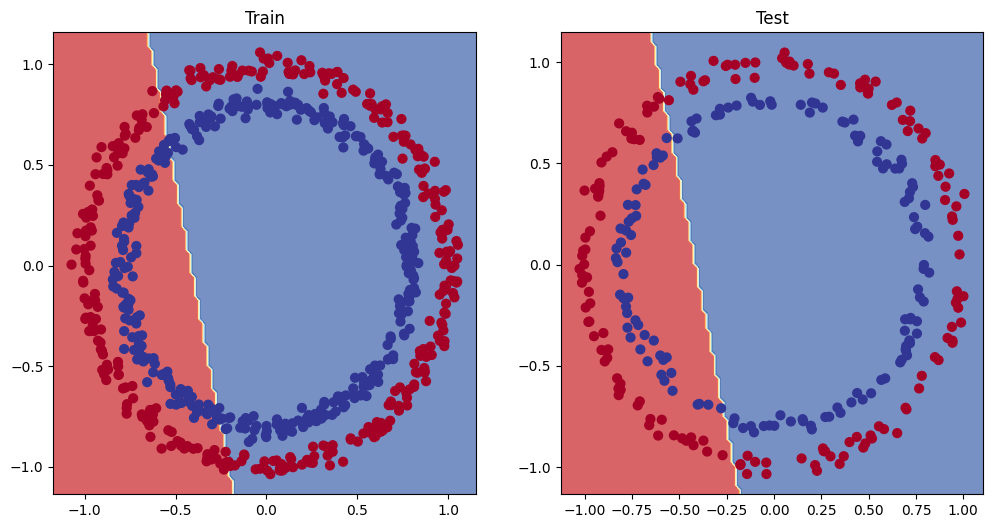

In [18]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

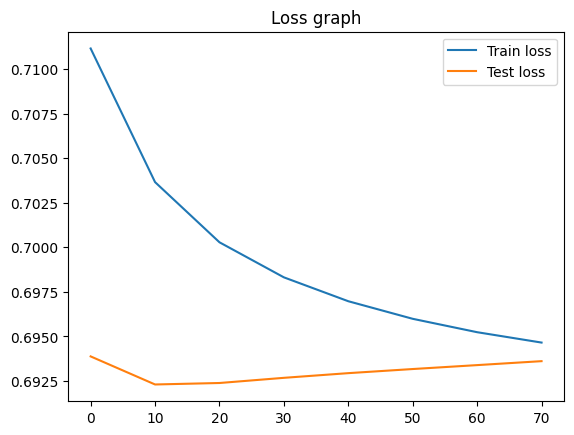

In [19]:
plt.plot(epoch_count, train_loss_values, label = "Train loss")
plt.plot(epoch_count, test_loss_values, label = "Test loss")
plt.title("Loss graph")
plt.legend()
plt.show()

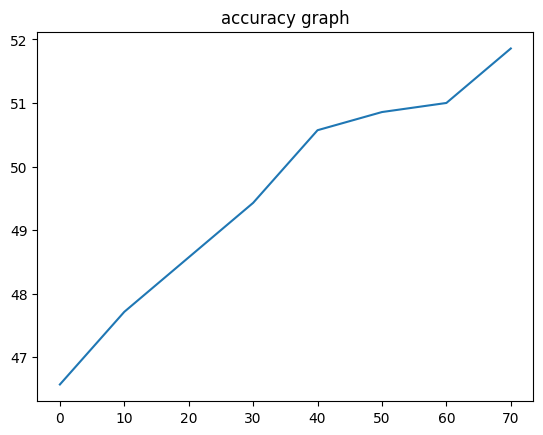

In [20]:
plt.plot(epoch_count, train_accuracy_score)
plt.title("accuracy graph")
plt.show()

* As seen in the graphs above it is pretty evident that the `train loss`, `test loss` as well as `train accuracy score` have stayed constant

* These observations mean that the model is unable to understand the patterns in the dataset. We will have to improve the model and do visualization

* I have tested this model on alot various epoch values and the model seems to only distinguish between dataset in a linear fashion and has not been able to predict the circular shape of the dataset

* We will have to improve the model in such a fashion that it becomes capable of detecting the circular dataset shape

# **Adding some non-linearity to the model**

* Introducing a ReLU activation function `torch.nn.ReLU()`

* Read more: https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/

# Redifining the model

* Adding extra hidden layer and increasing nodes

In [21]:
import torch
from torch import nn

class circle_model_v1(nn.Module): # subclassing nn.Module
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10) # Activation input layer; 2 to 5
    self.layer_2 = nn.Linear(in_features=10, out_features=10) # Hidden layer 1 ; 10 to 10
    self.layer_3 = nn.Linear(in_features=10, out_features=1) # Hidden layer 2; 0 to 1
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.layer_1(x))))

model_1 = circle_model_v1().to(device)
model_1

circle_model_v1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

# **Creating training loop**

In [22]:
# Creating Loss function
loss_fn_1 = nn.BCEWithLogitsLoss()

# Creating optimiser
optimiser_1 = torch.optim.SGD(model_1.parameters(), lr=0.1) # do not forget to setup which model you are looking to optuimise


In [23]:
import numpy as np

torch.manual_seed(101)

# X_train, y_train = X_train.to(device), y_train.to(device)
# X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 2000

epoch_count = []
train_loss_values = []
test_loss_values = []
train_accuracy_score = []

for epoch in range(epochs):

  model_1.train() # Setting the model on train mode

  _, y_logit = logit_to_bin(X_train) # getting logits for loss function nn.BCEWithLogitsLoss it works well with it

  y_pred, _ = logit_to_bin(X_train) # Performing forward pass and other operations

  train_loss = loss_fn_1(y_logit, y_train) # Passing the data to loss function

  train_acc = accuracy(y_pred, y_train) # Finding accuracy

  optimiser_1.zero_grad() # making optimiser accumulated values zero

  train_loss.backward() # Back propagation

  optimiser_1.step() # Activating optimiser

  model_1.eval() # Putting model on evaluation mode

  with torch.inference_mode():

    _, y_logit = logit_to_bin(X_test)

    y_pred,_ = logit_to_bin(X_test) # Testing the model

    test_loss = loss_fn_1(y_logit, y_test)

    test_acc = accuracy(y_pred, y_test)

    if epoch % 100 == 0:

      epoch_count.append(epoch)
      train_loss_values.append(train_loss.detach().numpy()) # converting values from tensor to numpy for later plotting
      test_loss_values.append(test_loss.detach().numpy()) # same as above
      train_accuracy_score.append(train_acc)

      print(f"Epoch : {epoch} | Train loss: {train_loss} | Test loss: {test_loss} | Train Accuracy : {round(train_acc,2)}% | Test Accuracy : {round(test_acc,2)}%")

Epoch : 0 | Train loss: 0.6942031383514404 | Test loss: 0.6938202977180481 | Train Accuracy : 51.57% | Test Accuracy : 51.67%
Epoch : 100 | Train loss: 0.6942031383514404 | Test loss: 0.6938202977180481 | Train Accuracy : 51.57% | Test Accuracy : 51.67%
Epoch : 200 | Train loss: 0.6942031383514404 | Test loss: 0.6938202977180481 | Train Accuracy : 51.57% | Test Accuracy : 51.67%
Epoch : 300 | Train loss: 0.6942031383514404 | Test loss: 0.6938202977180481 | Train Accuracy : 51.57% | Test Accuracy : 51.67%
Epoch : 400 | Train loss: 0.6942031383514404 | Test loss: 0.6938202977180481 | Train Accuracy : 51.57% | Test Accuracy : 51.67%
Epoch : 500 | Train loss: 0.6942031383514404 | Test loss: 0.6938202977180481 | Train Accuracy : 51.57% | Test Accuracy : 51.67%
Epoch : 600 | Train loss: 0.6942031383514404 | Test loss: 0.6938202977180481 | Train Accuracy : 51.57% | Test Accuracy : 51.67%
Epoch : 700 | Train loss: 0.6942031383514404 | Test loss: 0.6938202977180481 | Train Accuracy : 51.57% | T

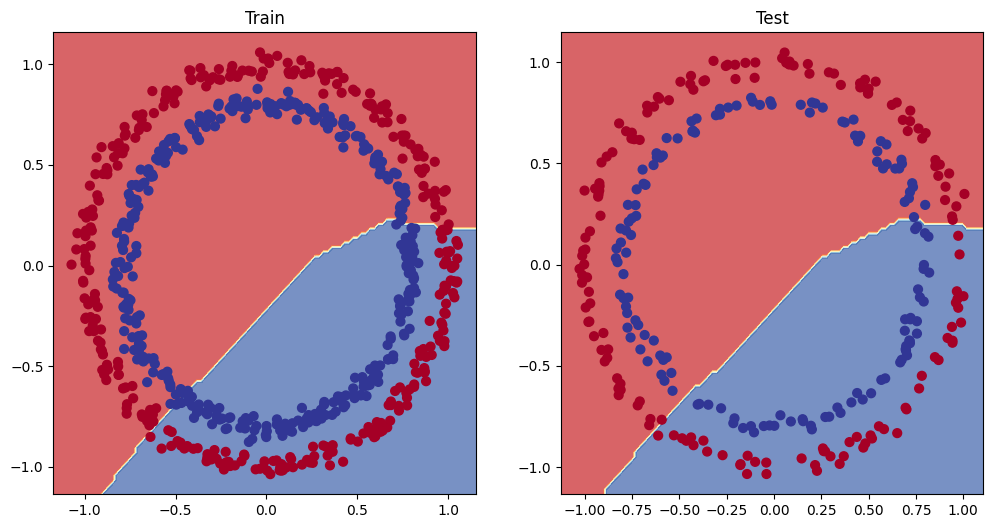

In [24]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

* As seen above the model is trying to get itself wrapped around the dataset trying to undersrtand the pattern



# **Understanding ReLU function**
* Replicating ReLU

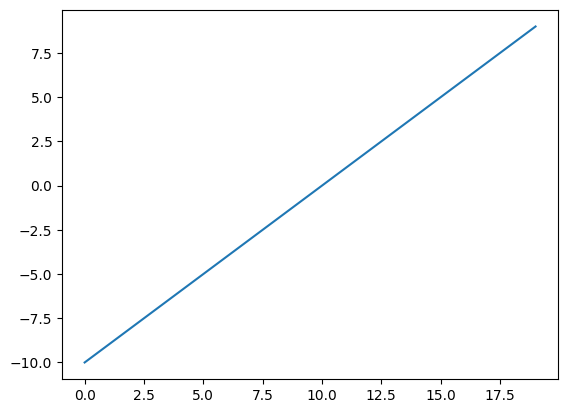

In [25]:
import torch
A = torch.arange(-10,10,1, dtype=torch.float32)
plt.plot(A)
plt.show()

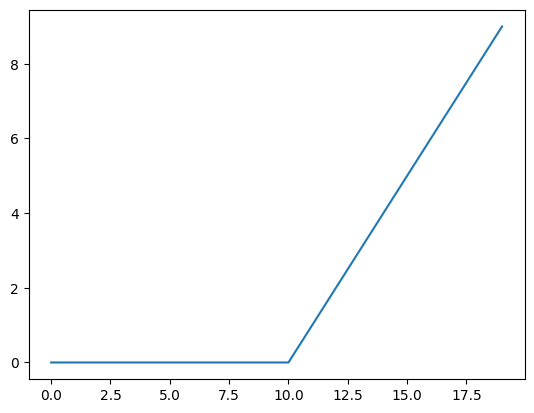

In [26]:
# defining relu's operation; it converts every -ve value to z

def relu(A):
  return torch.maximum(torch.tensor(0), A)

plt.plot(relu(A))

# **Replicating Sigmoid**

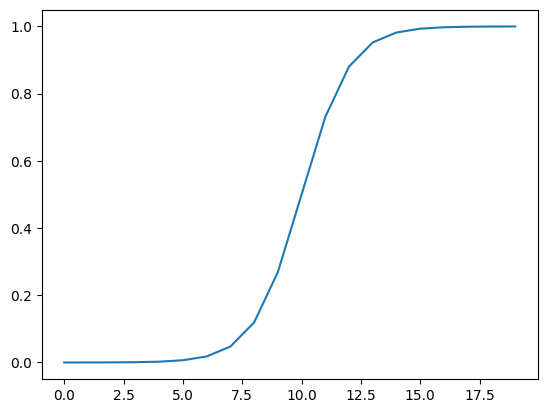

In [27]:
def sigmoid(x):
  return 1/(1+torch.exp(-x))

plt.plot(sigmoid(A))

# **Putting it all together**
* Creating multi-class data and training the model

* Creating blob dataset

In [28]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [29]:
X, y = make_blobs(n_samples=1000, centers=4, n_features=2, random_state=101) # Creating blob dataset

X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101) # train and test split

len(X_train), len(X_test), len(y_train), len(y_test)

(700, 300, 700, 300)

In [30]:
X_train.dtype, y_train.dtype

(torch.float32, torch.float32)

In [31]:
X_train[:5], y_train[:5]

(tensor([[-1.5558,  0.0992],
         [-4.4422,  9.8845],
         [ 0.6715,  1.6096],
         [-3.3635,  5.9869],
         [-4.2395,  6.2418]]),
 tensor([0., 3., 0., 3., 3.]))

**Plotting dataset**

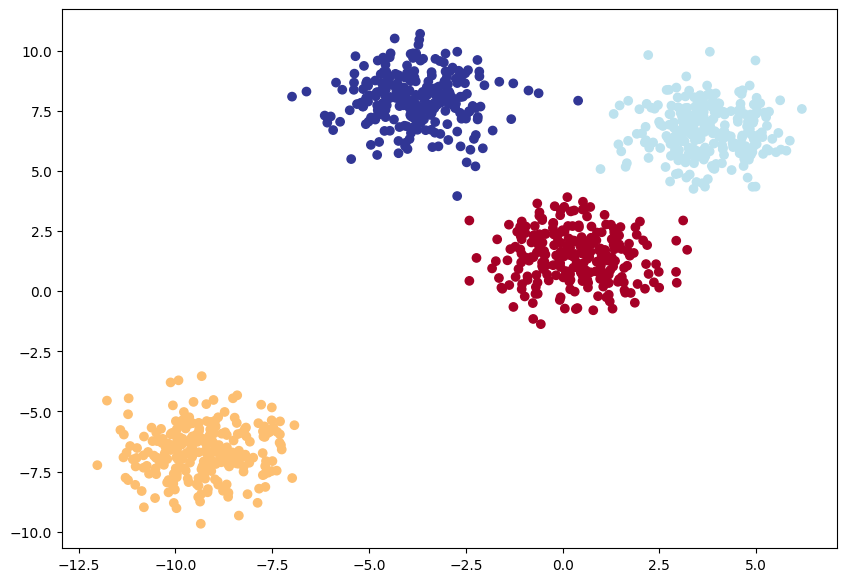

In [32]:
plt.figure(figsize=(10,7))
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu)
plt.show()

# **Building a multi-class model**

In [33]:
import torch
from torch import nn

class blob_model(nn.Module):
  def __init__(self, input_features, output_features, hidden_units):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),

        nn.Linear(in_features=hidden_units, out_features=hidden_units),

        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

model_2 = blob_model(input_features=2, hidden_units=8, output_features=4) # 2 imnput features
model_2

blob_model(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

**Creating loss function and optimiser**

* Cross entropy loss: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

In [34]:
# Creating loss function
loss_fn_2 = nn.CrossEntropyLoss()

# Creating optimiser
optimiser_2 = torch.optim.SGD(model_2.parameters(), lr=0.1)

**Understanding the output of model**

In [35]:
# Loking at logits, The output consist of 4 features which will be later turned into probabilities for each class

model_2.eval()

model_2(X_train)[:5]

tensor([[-0.5051, -0.2076, -0.3329, -0.4052],
        [-2.1317, -0.3491, -1.3693, -3.4132],
        [-0.3093,  0.0550, -0.4954, -0.1995],
        [-1.4956, -0.3003, -0.9564, -2.2329],
        [-1.6719, -0.3892, -0.9826, -2.5120]], grad_fn=<SliceBackward0>)

In [36]:
y_logit = model_2(X_train)

y_pred_prob = torch.softmax(y_logit, dim=1)

print(y_logit[:5])
y_pred_prob[:5]

tensor([[-0.5051, -0.2076, -0.3329, -0.4052],
        [-2.1317, -0.3491, -1.3693, -3.4132],
        [-0.3093,  0.0550, -0.4954, -0.1995],
        [-1.4956, -0.3003, -0.9564, -2.2329],
        [-1.6719, -0.3892, -0.9826, -2.5120]], grad_fn=<SliceBackward0>)


tensor([[0.2155, 0.2902, 0.2561, 0.2382],
        [0.1068, 0.6347, 0.2289, 0.0296],
        [0.2280, 0.3282, 0.1893, 0.2545],
        [0.1539, 0.5086, 0.2639, 0.0736],
        [0.1422, 0.5130, 0.2834, 0.0614]], grad_fn=<SliceBackward0>)

In [37]:
torch.sum(y_pred_prob[0]) # After the softmax function the output adds up to 1 beacause all are probsbility destribution

tensor(1.0000, grad_fn=<SumBackward0>)

In [38]:
print(y_pred_prob[11])
print(torch.argmax(y_pred_prob[11])) # The argmax shows that out of all the probabilites from all the 4 classes which class has the max probability accordig to the model

tensor([0.1493, 0.1177, 0.5198, 0.2133], grad_fn=<SelectBackward0>)
tensor(2)


In [39]:
y_logit.shape, y_train.shape

(torch.Size([700, 4]), torch.Size([700]))

In [40]:
y_pred = torch.argmax(y_pred_prob[11], dim = 0)

y_pred, y_train.dtype

(tensor(2), torch.float32)

# **Creating training loop**

In [41]:
y_train= y_train.long()

In [45]:
y_test = y_test.long()

In [46]:
import torch

torch.manual_seed(101)

epochs = 100

for epoch in range(epochs):

  model_2.train()

  y_logit = model_2(X_train)

  y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # logits -> prediction probabilities -> predicted class

  train_loss  = loss_fn_2(y_logit, y_train)

  acc = accuracy(y_pred=y_pred, y_test=y_train)

  optimiser_2.zero_grad()

  train_loss.backward()

  optimiser_2.step()

  model_2.eval()

  with torch.inference_mode():

    y_logit = model_2(X_test)

    y_pred = torch.softmax(y_logit, dim =1).argmax(dim=1)

    test_loss = loss_fn_2(y_logit, y_test)

    test_acc = accuracy(y_pred=y_pred, y_test=y_test)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {train_loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")




Epoch: 0 | Loss: 1.16707, Acc: 48.86% | Test Loss: 0.97646, Test Acc: 52.33%
Epoch: 10 | Loss: 0.47886, Acc: 77.57% | Test Loss: 0.43779, Test Acc: 79.67%
Epoch: 20 | Loss: 0.33578, Acc: 86.29% | Test Loss: 0.31397, Test Acc: 88.33%
Epoch: 30 | Loss: 0.26252, Acc: 93.43% | Test Loss: 0.24553, Test Acc: 94.00%
Epoch: 40 | Loss: 0.20726, Acc: 97.29% | Test Loss: 0.19307, Test Acc: 97.00%
Epoch: 50 | Loss: 0.16319, Acc: 98.57% | Test Loss: 0.15129, Test Acc: 98.33%
Epoch: 60 | Loss: 0.12877, Acc: 99.14% | Test Loss: 0.11886, Test Acc: 100.00%
Epoch: 70 | Loss: 0.10267, Acc: 99.29% | Test Loss: 0.09444, Test Acc: 100.00%
Epoch: 80 | Loss: 0.08323, Acc: 99.29% | Test Loss: 0.07637, Test Acc: 100.00%
Epoch: 90 | Loss: 0.06880, Acc: 99.29% | Test Loss: 0.06303, Test Acc: 100.00%


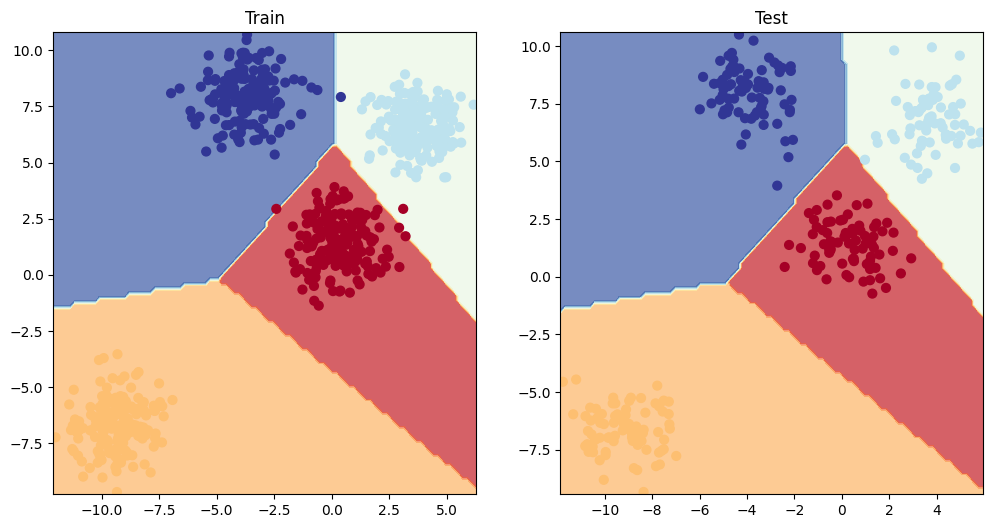

In [47]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)

In [49]:
import pandas as pd

df_data = {
    "X1": X[:,0],
    "X2": X[:,1],
    "Y": y,
}

df = pd.DataFrame(df_data)

In [50]:
df

,X1,X2,Y
0,0.311998,-0.019779,0.0
1,-8.167220,-6.032602,1.0
2,-4.335668,8.531199,3.0
3,-11.342064,-6.907616,1.0
4,-9.895231,-6.065536,1.0
...,...,...,...
995,-3.933775,7.332424,3.0
996,-3.508441,8.482032,3.0
997,-0.204498,3.531079,0.0
998,-4.461828,6.665581,3.0


from matplotlib import pyplot as plt
df['X1'].plot(kind='hist', bins=20, title='X1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['X2'].plot(kind='hist', bins=20, title='X2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['Y'].plot(kind='hist', bins=20, title='Y')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='X1', y='X2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='X2', y='Y', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['X1'].plot(kind='line', figsize=(8, 4), title='X1')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['X2'].plot(kind='line', figsize=(8, 4), title='X2')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['Y'].plot(kind='line', figsize=(8, 4), title='Y')
plt.gca().spines[['top', 'right']].set_visible(False)

* The above dataset training is a part of unsupervised learning where the model learns to understand pattern without getting any labeled data